# (Deprecated) Analysing pore dimensions with HOLE

Here we use `HOLE` to analyse pore dimensions in a membrane.

<div class="alert alert-warning">
    
**Warning**

The `MDAnalysis.analysis.hole` is now deprecated in favor of `MDAnalysis.analysis.hole2`, and will be removed in 2.0.0. Please see the [updated notebook](hole2.ipynb) for the updated tutorial.
</div>

**Last executed:** May 18, 2021 with MDAnalysis 1.1.1

**Last updated:** January 2020

**Minimum version of MDAnalysis:** 0.18.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests
* [HOLE](http://www.holeprogram.org)
* matplotlib
* numpy

<div class="alert alert-info">
    
**Note**

The classes in `MDAnalysis.analysis.hole` are wrappers around the HOLE program. Please cite (<a data-cite="smart_pore_1993" href="https://doi.org/10.1016/S0006-3495(93)81293-1">Smart *et al.*, 1993</a>, <a data-cite="smart_hole_1996" href="https://doi.org/10.1016/s0263-7855(97)00009-x">Smart *et al.*, 1996</a>) when using this module in published work.

</div>

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PDB_HOLE
from MDAnalysis.analysis import hole
import matplotlib.pyplot as plt
%matplotlib inline

## Using HOLE with a PDB file

`MDAnalysis.analysis.hole.HOLE` is a wrapper class ([API docs](https://docs.mdanalysis.org/stable/documentation_pages/analysis/hole2.html)) that calls the [HOLE](http://www.holeprogram.org) program. This means you must have installed the program yourself before you can use the class. You then need to pass the path to your ``hole`` executable to the class; in this example, ``hole`` is installed at ``~/hole2/exe/hole``.

HOLE defines a series of points throughout the pore from which a sphere can be generated that does not overlap any atom (as defined by its van der Waals radius). (Please see (<a data-cite="smart_pore_1993" href="https://doi.org/10.1016/S0006-3495(93)81293-1">Smart *et al.*, 1993</a>, <a data-cite="smart_hole_1996" href="https://doi.org/10.1016/s0263-7855(97)00009-x">Smart *et al.*, 1996</a>) for a complete explanation). By default, it ignores residues with the following names: "SOL", "WAT", "TIP", "HOH", "K  ", "NA ", "CL ". You can change these with the ``ignore_residues`` keyword. Note that the residue names must have 3 characters. Wildcards *do not* work.

The PDB file here is the experimental structure of the Gramicidin A channel. Note that we pass `HOLE` a PDB file directly, without creating a `MDAnalysis.Universe`.

In [2]:
h = hole.HOLE(PDB_HOLE, executable='~/hole2/exe/hole',
              logfile='hole1.out',
              sphpdb='hole1.sph',
              raseed=31415)
h.run()
h.collect()

This will create several outputs in your directory:

 - **hole1.out**: the log file for HOLE. 
 - **hole1.sph**: a PDB-like file containing the coordinates of the pore centers.
 - **simple2.rad**: file of Van der Waals' radii
 - **run_n/radii_n_m.dat.gz**: the profile for each frame
 - **tmp/pdb_name.pdb**: the short name of a PDB file with your structure. As `hole` is a FORTRAN77 program, it is limited in how long of a filename that it can read. 
 
 
 The pore profile itself is in a dictionary at `h.profiles`. There is only one frame in this PDB file, so it is at `h.profiles[0]`.

In [3]:
len(h.profiles[0])

425

Each profile is a ``numpy.recarray`` with the fields below as an entry for each `rxncoord`: 

  - **frame**: the integer frame number
  - **rxncoord**: the distance along the pore axis in angstrom
  - **radius**: the pore radius in angstrom

In [4]:
h.profiles[0].dtype.names

('frame', 'rxncoord', 'radius')

You can then proceed with your own analysis of the profiles. 

In [5]:
rxncoords = h.profiles[0].rxncoord
pore_length = rxncoords[-1] - rxncoords[0]
print('The pore is {} angstroms long'.format(pore_length))

The pore is 42.4 angstroms long


Both `HOLE` and `HOLEtraj` (below) have the `min_radius()` function, which will return the minimum radius in angstrom for each frame. The resulting array has the shape (#n_frames, 2).

In [6]:
h.min_radius()

array([[0.     , 1.19707]])

The class has a convenience `plot()` method to plot the coordinates of your pore.

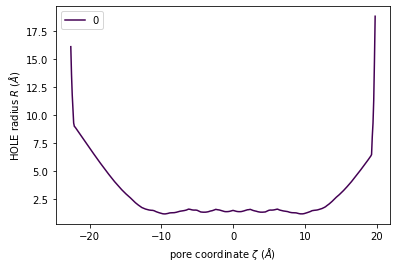

In [7]:
h.plot();

You can also create a VMD surface from the `hole1.sph` output file, using the `create_vmd_surface` function.

In [8]:
h.create_vmd_surface(filename='hole1.vmd')

'hole1.vmd'

To view this, open your PDB file in VMD.

`vmd tmp*/*.pdb`

Load the output file in Extensions > Tk Console:

`source hole1.vmd`

Your pore surface will be drawn as below.

<center>
<div style="width:200px; text-align:center;">

![sphpdb.png](sphpdb.png)
    
</div>
</center>

MDAnalysis supports many of the options that can be customised in HOLE. For example, you can specify a starting point for the pore search within the pore with `cpoint`, and a ``sample`` distance (default: 0.2 angstrom) for the distance between the planes used in HOLE. Please see the [MDAnalysis.analysis.hole](https://www.mdanalysis.org/docs/documentation_pages/analysis/hole.html) for more information.

## Using HOLE with a trajectory

One of the limitations of the ``hole`` program is that it can only accept PDB files. In order to use other formats with ``hole``, or to run ``hole`` on trajectories, we can use the ``hole.HOLEtraj`` class with an ``MDAnalysis.Universe``. While the example file below is a PDB, you can use any files to create your Universe.

In [9]:
from MDAnalysis.tests.datafiles import MULTIPDB_HOLE

u = mda.Universe(MULTIPDB_HOLE)

ht = hole.HOLEtraj(u, executable='~/hole2/exe/hole',
                   logfile='hole2.out',
                   sphpdb='hole2.sph')
ht.run()

/Users/lily/anaconda3/envs/mda-user-guide/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:864: DeprecationWarning: Using the last letter of the segid for the chainID is now deprecated and will be changed in 2.0. In 2.0, the chainID attribute will be used if it exists, or a placeholder value.
  "exists, or a placeholder value.", DeprecationWarning)


Note that you do not need call `collect()` after calling `run()` with `HOLEtraj`. Again, the data is stored in `ht.profiles` as a dictionary of `numpy.recarray`s. The dictionary is indexed by frame; we can see the HOLE profile for the fourth frame below (truncated to 19.1126 angstrom from the pore axis). In this case, the `frame` field of each `recarray` is always 0.

In [10]:
ht.profiles[3][:10]

rec.array([(0, -18.6126, 16.58975), (0, -18.5126, 13.39834),
           (0, -18.4126, 10.82539), (0, -18.3126,  8.86034),
           (0, -18.2126,  7.28037), (0, -18.1126,  6.4542 ),
           (0, -18.0126,  6.48675), (0, -17.9126,  6.39647),
           (0, -17.8126,  6.30656), (0, -17.7126,  6.21605)],
          dtype=[('frame', '<i4'), ('rxncoord', '<f8'), ('radius', '<f8')])

Again, `plot()` can plot the HOLE radius over each pore coordinate, differentiating each frame with colour.

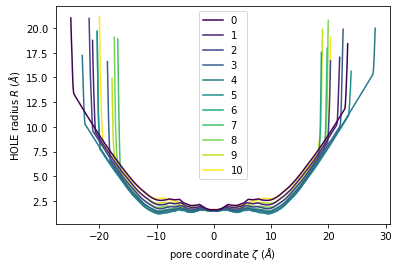

In [11]:
ht.plot();

The `plot3D()` function separates each frame onto its own axis in a 3D plot.

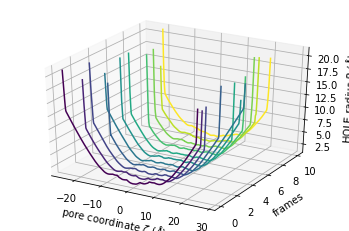

In [12]:
ht.plot3D();

## Ordering HOLE profiles with an order parameter

If you are interested in the HOLE profiles over an order parameter, you can directly pass that into the analysis. Below, we use an order parameter of RMSD from a reference structure.

<div class="alert alert-info">
    
**Note**

Please cite (<a data-cite="stelzl_flexible_2014" href="https://doi.org/10.1016/j.jmb.2013.10.024">Stelzl *et al.*, 2014</a>) when using the ``orderparameter`` functionality.

</div>

In [13]:
from MDAnalysis.analysis import rms

ref = mda.Universe(PDB_HOLE)
rmsd = rms.RMSD(u, ref, select='protein', weights='mass').run()
rmsd_values = rmsd.rmsd[:, 2]
rmsd_values

array([6.10501252e+00, 4.88398472e+00, 3.66303524e+00, 2.44202454e+00,
       1.22100521e+00, 2.36577481e-07, 1.22100162e+00, 2.44202456e+00,
       3.66303410e+00, 4.88398478e+00, 6.10502262e+00])

You can pass this in as `orderparameter`. The result `profiles` dictionary will have your order parameters as keys. **You should be careful with this if your order parameter has repeated values, as duplicate keys are not possible; each duplicate key just overwrites the previous value.**

In [14]:
ht2 = hole.HOLEtraj(u, executable='~/hole2/exe/hole',
                    logfile='hole3.out',
                    sphpdb='hole3.sph',
                    orderparameters=rmsd_values)
ht2.run()
ht2.profiles.keys()

/Users/lily/anaconda3/envs/mda-user-guide/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:864: DeprecationWarning: Using the last letter of the segid for the chainID is now deprecated and will be changed in 2.0. In 2.0, the chainID attribute will be used if it exists, or a placeholder value.
  "exists, or a placeholder value.", DeprecationWarning)


odict_keys([6.1050125197092, 4.883984723991119, 3.663035235691455, 2.442024543243412, 1.2210052104208522, 2.3657748143998805e-07, 1.2210016190719406, 2.4420245634673843, 3.663034099295049, 4.883984778674987, 6.105022620520385])

You can see here that the dictionary does not order the entries by the order parameter. If you iterate over the class, it will return each (key, value) pair in sorted key order.

In [15]:
for order_parameter, profile in ht2:
    print(order_parameter, len(profile))

2.3657748143998805e-07 413
1.2210016190719406 443
1.2210052104208522 517
2.442024543243412 435
2.4420245634673843 345
3.663034099295049 397
3.663035235691455 421
4.883984723991119 433
4.883984778674987 393
6.1050125197092 467
6.105022620520385 403


We can use this to plot the minimum radius as a function of RMSD from the reference structure.

Text(0, 0.5, 'minimum HOLE pore radius $r$ ($\\AA$)')

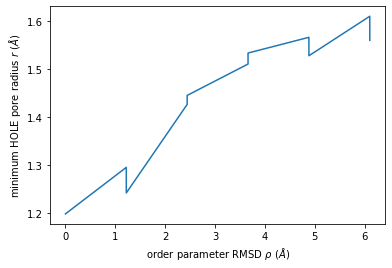

In [16]:
import numpy as np
import matplotlib.pyplot as plt

min_radius = [[rmsd_i, p.radius.min()] for rmsd_i, p in ht2]
arr = np.array(min_radius)

plt.plot(arr[:, 0], arr[:, 1])
plt.xlabel(r"order parameter RMSD $\rho$ ($\AA$)")
plt.ylabel(r"minimum HOLE pore radius $r$ ($\AA$)");

## References

[1] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[2] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.

[3] O&nbsp;S Smart, J&nbsp;M Goodfellow, and B&nbsp;A Wallace.
The pore dimensions of gramicidin <span class="bibtex-protected">A</span>.
<em>Biophysical Journal</em>, 65(6):2455–2460, December 1993.
00522.
URL: <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1225986/">https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1225986/</a>, <a href="https://doi.org/10.1016/S0006-3495(93)81293-1">doi:10.1016/S0006-3495(93)81293-1</a>.

[4] O.&nbsp;S. Smart, J.&nbsp;G. Neduvelil, X.&nbsp;Wang, B.&nbsp;A. Wallace, and M.&nbsp;S. Sansom.
<span class="bibtex-protected">HOLE</span>: a program for the analysis of the pore dimensions of ion channel structural models.
<em>Journal of Molecular Graphics</em>, 14(6):354–360, 376, December 1996.
00935.
<a href="https://doi.org/10.1016/s0263-7855(97)00009-x">doi:10.1016/s0263-7855(97)00009-x</a>.

[5] Lukas&nbsp;S. Stelzl, Philip&nbsp;W. Fowler, Mark S.&nbsp;P. Sansom, and Oliver Beckstein.
Flexible gates generate occluded intermediates in the transport cycle of <span class="bibtex-protected">LacY</span>.
<em>Journal of Molecular Biology</em>, 426(3):735–751, February 2014.
00000.
URL: <a href="https://asu.pure.elsevier.com/en/publications/flexible-gates-generate-occluded-intermediates-in-the-transport-c">https://asu.pure.elsevier.com/en/publications/flexible-gates-generate-occluded-intermediates-in-the-transport-c</a>, <a href="https://doi.org/10.1016/j.jmb.2013.10.024">doi:10.1016/j.jmb.2013.10.024</a>.